In [20]:
from AutoEncoders import ReLUSAE
from Utils import createImageDataloader
from transformers import CLIPVisionModel
import torch
from torch.optim import Adam
from Visualizations import plotActivation

In [21]:
loader = createImageDataloader("/Users/mawy/Desktop/Square 512", model_name="openai/clip-vit-base-patch32", batch_size=64, shuffle=False)

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").eval()
model.config.output_hidden_states = True
CLS_LAYER = 6         

SAE = ReLUSAE(input_dim=768, num_features=3072, lam=4.0)

alpha = SAE.estimateAlpha(
    dataloader   = loader,
    feature_model= model,
    num_batches  = 5,
    layer        = CLS_LAYER, 
)
print("α =", alpha)

SAE.findBias(
    vit        = model,
    dataloader = loader,
    n          = 5, 
    layer      = CLS_LAYER,
)

α = 4.7143356421449525
[LOG] Bias initialized to Geometric Median


In [ ]:
epochs = 5
optimizer = Adam(SAE.parameters(), lr=1e-3)

for epoch in range(epochs):
    for i, batch in enumerate(loader):

        images = batch[0] if isinstance(batch, (tuple, list)) else batch

        with torch.no_grad():
            feats = model(pixel_values=images).hidden_states[CLS_LAYER][:, 0]

        loss = SAE.loss(feats)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    SAE.renorm()
    print(f"Epoch {epoch+1}/{epochs}  |  Total Loss = {loss.item():.4f}")

Epoch 1/5  |  Total Loss = 40624.9102
Epoch 2/5  |  Total Loss = 30585.4219


In [ ]:
batch = next(iter(loader))
with torch.no_grad():
    feats = model(pixel_values=batch).hidden_states[CLS_LAYER][:, 0]
latents = SAE(feats)[1][0,:].detach().cpu().numpy()

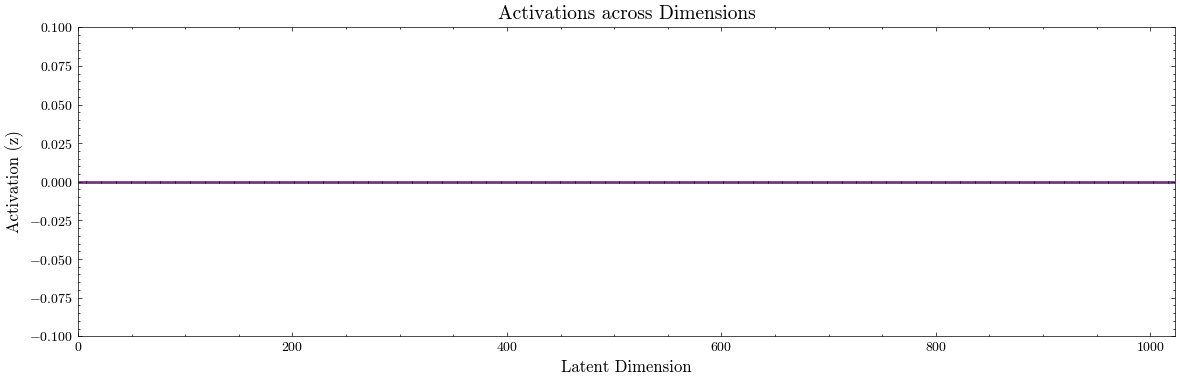

In [ ]:
plotActivation(latents)